# Urban Air Pollution Challenge

### Can you predict air quality in cities around the world using satellite data?

The objective of this challenge is to predict PM2.5 particulate matter concentration in the air every day for each city. PM2.5 refers to atmospheric particulate matter that have a diameter of less than 2.5 micrometers and is one of the most harmful air pollutants. PM2.5 is a common measure of air quality that normally requires ground-based sensors to measure. The data covers the last three months, spanning hundreds of cities across the globe.

In [28]:
#First, our imports

import os
import joblib
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro

from sklearn import set_config
set_config(transform_output='pandas') #we don't need to do set_config if we don't 
                                      #care about our .transform outputting a data frame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
#We have loaded the CSV containing our data in the data folder under "pollution.csv" 
#Below we load it in:

df = pd.read_csv('data/pollution.csv')


In [30]:
#Now we get a very basic preview of it
df.head()

#notice that the place_ID and date appear in individual columns and a combined column
#according to the format of solutions for this task, we must use the column which has them
#combined

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df.sort_values(by='target', ascending=False).head(30)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
4453,426FKUG X 2020-02-09,2020-02-09,426FKUG,815.0,82.0,815.0,1188380.0,40,8.471429,23.442857,...,8.056621,-157.709027,39.146939,1859.337138,2727.946435,0.033287,67.984756,7.997689,-157.649837,39.133057
4456,426FKUG X 2020-02-12,2020-02-12,426FKUG,815.0,2.0,815.0,1318070.0,46,12.528572,29.471429,...,57.442645,-142.722236,43.375964,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4455,426FKUG X 2020-02-11,2020-02-11,426FKUG,815.0,61.0,815.0,1261770.0,41,15.014286,35.628573,...,58.396401,-171.728926,36.234062,1834.629935,2908.857049,0.014343,66.298831,58.435925,-171.606018,36.139873
4465,426FKUG X 2020-02-21,2020-02-21,426FKUG,815.0,60.0,815.0,1363900.0,41,9.671429,15.171429,...,46.851716,-165.142246,33.428196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8173,8ZGB2UV X 2020-01-05,2020-01-05,8ZGB2UV,689.0,308.0,999.0,348065.0,72,28.878614,41.366667,...,19.202997,-66.029434,24.776411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8170,8ZGB2UV X 2020-01-02,2020-01-02,8ZGB2UV,470.0,185.0,668.0,154228.0,72,8.700000,28.166667,...,59.853695,-64.461987,26.603615,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30300,YPXSK14 X 2020-01-11,2020-01-11,YPXSK14,465.0,438.0,562.0,15664.7,120,5.216144,81.120001,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30299,YPXSK14 X 2020-01-10,2020-01-10,YPXSK14,410.0,274.0,545.0,54175.8,139,4.260000,53.360002,...,51.369837,-173.064110,66.768517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17607,IM6VR3X X 2020-01-04,2020-01-04,IM6VR3X,400.0,173.0,538.0,120373.0,24,11.700000,56.200001,...,36.955452,-168.578931,55.190426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30301,YPXSK14 X 2020-01-12,2020-01-12,YPXSK14,397.0,151.0,562.0,181282.0,124,5.900000,97.920001,...,31.022997,-162.434681,67.474728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Get to know the features

* precipitable_water_entire_atmosphere: The total amount of water vapor in a vertical column of the atmosphere.
* relative_humidity_2m_above_ground: The percentage of water vapor in the air relative to the maximum it can hold at 2 meters above ground level.
* specific_humidity_2m_above_ground: The mass of water vapor per unit mass of air at 2 meters above ground level.
* temperature_2m_above_ground: The air temperature measured 2 meters above the ground.
* u_component_of_wind_10m_above_ground: The east-west (horizontal) component of wind speed at 10 meters above ground level.
* v_component_of_wind_10m_above_ground: The north-south (horizontal) component of wind speed at 10 meters above ground level.
* L3_NO2_NO2_column_number_density: The total vertical column density of nitrogen dioxide (NO₂) in the atmosphere.
* L3_NO2_NO2_slant_column_number_density: The slant column density of nitrogen dioxide (NO₂) measured along the sensor’s line of sight.
* L3_NO2_absorbing_aerosol_index: A measure of the presence of absorbing aerosols like dust and smoke in the atmosphere based on NO₂ data.
* L3_NO2_cloud_fraction: The fraction of the observed area covered by clouds in NO₂ measurements.
* L3_NO2_sensor_altitude: The altitude of the satellite sensor when measuring NO₂.
* L3_NO2_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to NO₂ measurements.
* L3_NO2_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for NO₂ measurements.
* L3_NO2_solar_azimuth_angle: The azimuthal angle of the sun relative to NO₂ measurements.
* L3_NO2_solar_zenith_angle: The angle between the sun's rays and the vertical direction for NO₂ measurements.
* L3_NO2_stratospheric_NO2_column_number_density: The amount of NO₂ in the stratospheric vertical column of the atmosphere.
* L3_NO2_tropopause_pressure: The pressure at the boundary between the troposphere and the stratosphere for NO₂ measurements.
* L3_NO2_tropospheric_NO2_column_number_density: The amount of NO₂ in the tropospheric vertical column of the atmosphere.
* L3_O3_O3_column_number_density: The total vertical column density of ozone (O₃) in the atmosphere.
* L3_O3_O3_effective_temperature: The effective temperature of the ozone layer based on radiative transfer models.
* L3_O3_cloud_fraction: The fraction of the observed area covered by clouds in O₃ measurements.
* L3_O3_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to O₃ measurements.
* L3_O3_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for O₃ measurements.
* L3_O3_solar_azimuth_angle: The azimuthal angle of the sun relative to O₃ measurements.
* L3_O3_solar_zenith_angle: The angle between the sun's rays and the vertical direction for O₃ measurements.
* L3_CO_CO_column_number_density: The total vertical column density of carbon monoxide (CO) in the atmosphere.
* L3_CO_H2O_column_number_density: The total vertical column density of water vapor (H₂O) in the atmosphere based on CO data.
* L3_CO_cloud_height: The height of clouds in CO measurements.
* L3_CO_sensor_altitude: The altitude of the satellite sensor when measuring CO.
* L3_CO_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to CO measurements.
* L3_CO_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for CO measurements.
* L3_CO_solar_azimuth_angle: The azimuthal angle of the sun relative to CO measurements.
* L3_CO_solar_zenith_angle: The angle between the sun's rays and the vertical direction for CO measurements.
* L3_HCHO_HCHO_slant_column_number_density: The slant column density of formaldehyde (HCHO) measured along the sensor’s line of sight.
* L3_HCHO_cloud_fraction: The fraction of the observed area covered by clouds in HCHO measurements.
* L3_HCHO_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to HCHO measurements.
* L3_HCHO_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for HCHO measurements.
* L3_HCHO_solar_azimuth_angle: The azimuthal angle of the sun relative to HCHO measurements.
* L3_HCHO_solar_zenith_angle: The angle between the sun's rays and the vertical direction for HCHO measurements.
* L3_HCHO_tropospheric_HCHO_column_number_density: The amount of HCHO in the tropospheric vertical column of the atmosphere.
* L3_HCHO_tropospheric_HCHO_column_number_density_amf: The air mass factor applied to HCHO tropospheric column density.
* L3_CLOUD_cloud_base_height: The height of the base of clouds.
* L3_CLOUD_cloud_base_pressure: The atmospheric pressure at the base of clouds.
* L3_CLOUD_cloud_fraction: The fraction of the observed area covered by clouds.
* L3_CLOUD_cloud_optical_depth: A measure of the thickness of clouds based on their optical properties.
* L3_CLOUD_cloud_top_height: The height of the top of clouds.
* L3_CLOUD_cloud_top_pressure: The atmospheric pressure at the top of clouds.
* L3_CLOUD_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to cloud measurements.
* L3_CLOUD_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for cloud measurements.
* L3_CLOUD_solar_azimuth_angle: The azimuthal angle of the sun relative to cloud measurements.
* L3_CLOUD_solar_zenith_angle: The angle between the sun's rays and the vertical direction for cloud measurements.
* L3_CLOUD_surface_albedo: The fraction of solar energy reflected by the Earth's surface in cloud measurements.
* L3_AER_AI_absorbing_aerosol_index: A measure of the presence of absorbing aerosols like dust and smoke in the atmosphere.
* L3_AER_AI_sensor_altitude: The altitude of the satellite sensor when measuring aerosols.
* L3_AER_AI_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to aerosol measurements.
* L3_AER_AI_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for aerosol measurements.
* L3_AER_AI_solar_azimuth_angle: The azimuthal angle of the sun relative to aerosol measurements.
* L3_AER_AI_solar_zenith_angle: The angle between the sun's rays and the vertical direction for aerosol measurements.
* L3_SO2_SO2_column_number_density: The total vertical column density of sulfur dioxide (SO₂) in the atmosphere.
* L3_SO2_SO2_column_number_density_amf: The air mass factor applied to SO₂ column density.
* L3_SO2_SO2_slant_column_number_density: The slant column density of SO₂ measured along the sensor’s line of sight.
* L3_SO2_absorbing_aerosol_index: A measure of the presence of absorbing aerosols in the atmosphere based on SO₂ data.
* L3_SO2_cloud_fraction: The fraction of the observed area covered by clouds in SO₂ measurements.
* L3_SO2_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to SO₂ measurements.
* L3_SO2_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for SO₂ measurements.
* L3_SO2_solar_azimuth_angle: The azimuthal angle of the sun relative to SO₂ measurements.
* L3_SO2_solar_zenith_angle: The angle between the sun's rays and the vertical direction for SO₂ measurements.
* L3_CH4_CH4_column_volume_mixing_ratio_dry_air: The volume mixing ratio of methane (CH₄) in dry air.
* L3_CH4_aerosol_height: The height of aerosols in CH₄ measurements.
* L3_CH4_aerosol_optical_depth: A measure of the thickness of aerosols based on their optical properties in CH₄ data.
* L3_CH4_sensor_azimuth_angle: The azimuthal angle of the satellite sensor relative to CH₄ measurements.
* L3_CH4_sensor_zenith_angle: The angle between the sensor's line of sight and the vertical direction for CH₄ measurements.
* L3_CH4_solar_azimuth_angle: The azimuthal angle of the sun relative to CH₄ measurements.
* L3_CH4_solar_zenith_angle: The angle between the sun's rays and the vertical direction for CH₄ measurements.

## Get to know the target

The target is PM2.5 particle concentration. Recall that ground-based sensors are required in order to measure this. PM2.5 concentration refers to the amount of fine particulate matter in the air with a diameter of 2.5 micrometers or smaller. These tiny particles are generated from sources like vehicle emissions, industrial processes, wildfires, and chemical reactions in the atmosphere. Due to their small size, PM2.5 particles can penetrate deep into the lungs and even enter the bloodstream, posing serious health risks such as respiratory and cardiovascular diseases. PM2.5 is also a significant environmental concern, as it reduces visibility (haze) and contributes to poor air quality. Monitoring and controlling PM2.5 levels are crucial for protecting public health and the environment.


In addition to the target column (which is the daily mean concentration) there are also columns for minimum and maximum readings on that day, the variance of the readings and the total number (count) of sensor readings used to compute the target value. This data is only provided for the train set - we must predict the target variable for the test set


Since we have so many features it would be good to get to know these features first in order to determine which may be irrelevant for our target.


To identify features irrelevant for understanding PM2.5 (fine particulate matter) concentrations, it’s essential to focus on features directly or indirectly related to air quality and pollutant dynamics. Features related to weather, aerosols, and chemical composition of the atmosphere are generally relevant, while those unrelated to these aspects might be less informative.

Here, the unrelated columns are those related to sensor geometry/position and solar geometry so we remove them below. Additionally,

For most studies or analyses of PM2.5 concentrations at ground level:
* Focus on troposphere data as it is directly relevant to the sources, behavior, and health impacts of PM2.5 near the Earth's surface.
* Stratosphere data is generally not necessary for PM2.5 at ground level, unless you're studying specific events like long-range transport of pollutants or examining interactions with ozone, which are typically not the primary concern for ground-level PM2.5.
* So, you should primarily take troposphere data into account and generally ignore stratosphere data for assessing ground-level PM2.5 concentrations.

## Drop Irrelevant Features

There are some criteria for what we want to drop:

- Irrelevant features based on domain knowledge
- 1 feature from pairs of features that are strongly correlated with another


1. Irrelevant features:
* these are deemed as any which contain the sub-strings below in their column names:
    * solar, sensor, stratospheric, amf, slant
    * We save this data frame as df_cleaned

2. Correlated Features:
* In order to determine which features are correlated, we must make a data frame which only contains numerical data and call this df_num. From there we can visualize the correlation heatmap and set a threshold, above which we choose to drop one of the two correlated features.

## Choose relevant features

In [31]:
relevant_features = ['relative_humidity_2m_above_ground',
                     'specific_humidity_2m_above_ground',
                     'temperature_2m_above_ground',
                     'u_component_of_wind_10m_above_ground',
                     'v_component_of_wind_10m_above_ground',
                     'L3_NO2_tropospheric_NO2_column_number_density',     #this is the only NO2 feature we take
                     'L3_O3_O3_column_number_density',  #this is the only O3 feature we take
                     'L3_CO_CO_column_number_density' ,
                     'L3_CO_H2O_column_number_density',
                     'L3_HCHO_tropospheric_HCHO_column_number_density',
                     'L3_SO2_absorbing_aerosol_index',
                     'L3_AER_AI_absorbing_aerosol_index',
                     'L3_SO2_SO2_column_number_density'
                     ]

additional_cols = ['target']

In [32]:
#Create data frame which has relevant features and extra information

df_new = df[[col for col in relevant_features + additional_cols]]
df_new

,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density,L3_SO2_absorbing_aerosol_index,L3_AER_AI_absorbing_aerosol_index,L3_SO2_SO2_column_number_density,target
0,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000017,0.119095,0.021080,883.332451,0.000064,-1.861476,-1.231330,-0.000127,38.0
1,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000021,0.115179,0.022017,1148.985447,0.000171,-1.452612,-1.082553,0.000150,39.0
2,33.400002,0.00750,27.031030,5.065727,3.500559,0.000007,0.115876,0.020677,1109.347101,0.000124,-1.572950,-1.001241,0.000150,24.0
3,21.300001,0.00391,23.971857,3.004001,1.099468,0.000023,0.141557,0.021207,1061.570832,0.000081,-1.239317,-0.777023,0.000227,49.0
4,44.700001,0.00535,16.816309,2.621787,2.670559,0.000009,0.126369,0.037766,1044.247425,0.000140,0.202489,0.366324,0.000390,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30552,68.300003,0.00352,4.256799,-4.810586,-4.195359,0.000019,0.174995,0.039941,148.082862,0.000024,-1.953480,-1.412609,0.000312,22.0
30553,77.700005,0.00341,2.067438,-2.346421,0.749136,0.000033,0.157659,0.037872,308.441747,-0.000014,-2.178236,-1.448509,0.000362,53.0
30554,68.500000,0.00356,4.438623,0.095703,0.141943,0.000025,0.168295,0.038539,673.059505,0.000094,-2.365827,-1.722478,0.000107,85.0
30555,66.300003,0.00523,10.573236,0.434940,-1.439778,0.000038,0.160637,0.038757,957.667555,0.000063,-2.784346,-2.042785,0.000014,103.0


## Check feature correlation with target and each other

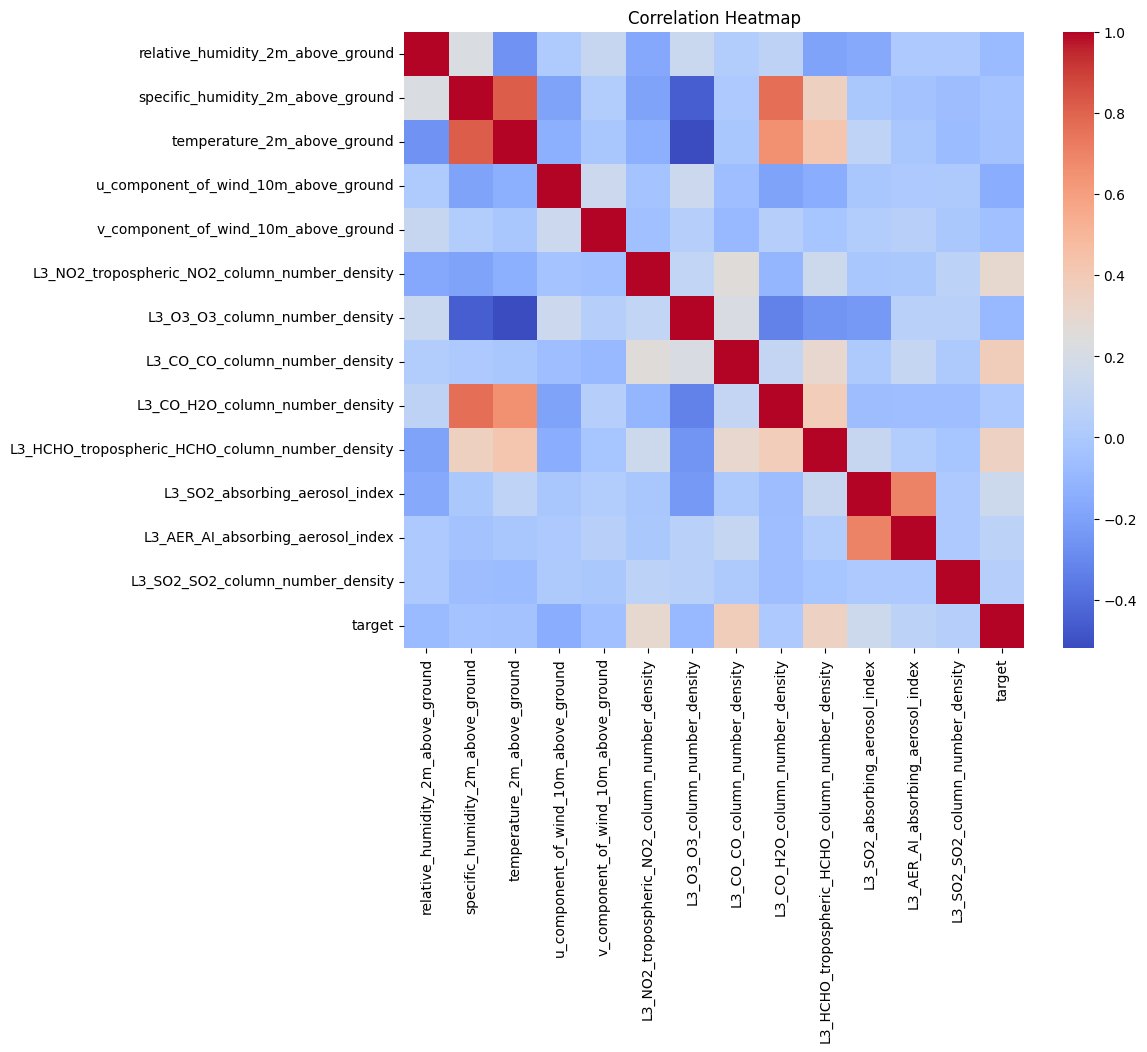

In [33]:
#Correlation matrix can only take numerical data

correlation_matrix = df_new.corr()


# Step 2: Visualize the correlation matrix (if only want to check visually, move to step 4)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [34]:
#Check if there are any correlations above 0.9
threshold = 0.9

# Find pairs of features with correlation above the threshold
correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.append((correlation_matrix.index[i], correlation_matrix.columns[j]))

# Display the list of correlated feature pairs
print("Correlated features (above threshold):")
correlated_features

Correlated features (above threshold):


[]

## Check the distribution of the target variable

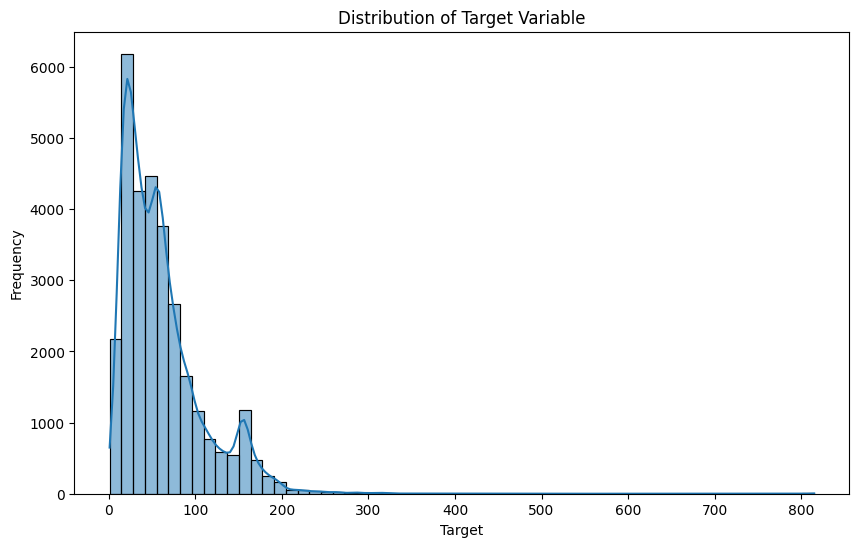

In [35]:
#Step 1: Visualize the target variable. If we only want to check visually, move to step 3
plt.figure(figsize=(10, 6))
sns.histplot(df_new['target'], kde=True, bins=60)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

/var/folders/p9/v7_vyxyx0dj05w7n_pckzw_m0000gp/T/ipykernel_39712/1075979576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['target_transformed'] = np.log1p(df_new['target'])


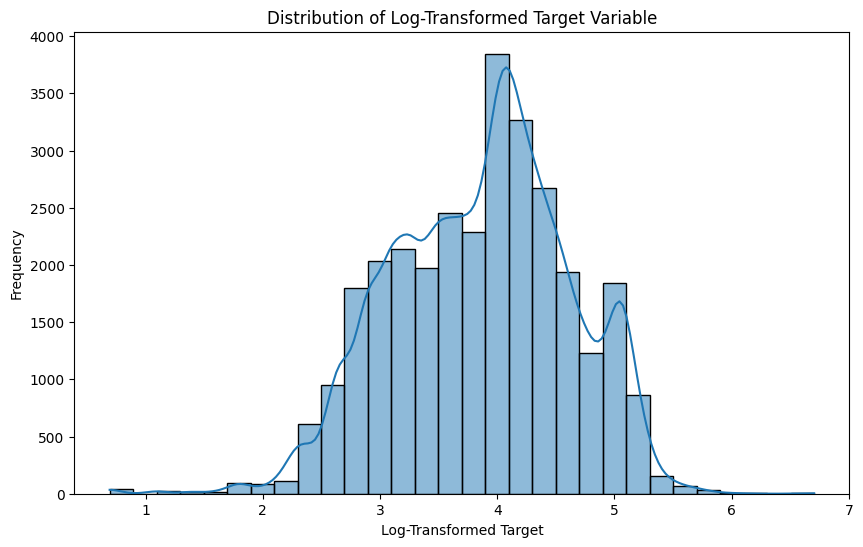

In [36]:
#Normalize the target variable (if not Gaussian)

# Apply log transformation (here use log1p since it is able to 
# handle 0 values, (computes log(1+x))):
df_new['target_transformed'] = np.log1p(df_new['target'])

#Visualize the transformed target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_new['target_transformed'], kde=True, bins=30)
plt.title('Distribution of Log-Transformed Target Variable')
plt.xlabel('Log-Transformed Target')
plt.ylabel('Frequency')
plt.show()

## Train-test-split

In [37]:
X = df_new.drop(['target_transformed'], axis=1)
y = df_new['target_transformed']

#Do the train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Feature Engineering

So far for feature engineering, we have learned a few column transformers:

1. Binning
2. Imputing
3. OneHot Encoding
4. Ordinal Encoding
5. Scaling

To Implement these transformations, we have two tools: Column Transformers and Pipelines:

* **Column Transformers**: allows for application of pipelines & singular tools to multiple columns at once (Note: cannot apply multiple changes to a single column, otherwise it will save multiple versions of the transformed column, each with only a single transformation on them)
* **Pipeline**: applies transformations in a sequence

### Imputing

In [38]:
#First let's check which rows are missing information

X_train.isna().sum().sort_values(ascending=False)

L3_NO2_tropospheric_NO2_column_number_density      6500
L3_HCHO_tropospheric_HCHO_column_number_density    5562
L3_SO2_absorbing_aerosol_index                     5458
L3_SO2_SO2_column_number_density                   5407
L3_CO_CO_column_number_density                     4056
L3_CO_H2O_column_number_density                    4056
L3_O3_O3_column_number_density                      213
L3_AER_AI_absorbing_aerosol_index                   146
relative_humidity_2m_above_ground                     0
specific_humidity_2m_above_ground                     0
temperature_2m_above_ground                           0
u_component_of_wind_10m_above_ground                  0
v_component_of_wind_10m_above_ground                  0
target                                                0
dtype: int64

In [39]:
#Almost all of the features are missing something. We want to see what the best imputation values will be for each, so it's a good idea 
#to check the distributions of each of the features with missing values.
#This will help us determine if we should impute with the mean, the median, etc

In [40]:
# Create histograms for each feature to check distribution and see best imputation method

# for col in X_train.columns:
#     plt.figure(figsize=(8, 5))  # Set the figure size
#     X_train[col].hist(bins=30, alpha=0.7, edgecolor='black')  # Create the histogram
#     plt.title(f'Histogram for {col}')  # Add title
#     plt.xlabel(col)  # Label the x-axis
#     plt.ylabel('Frequency')  # Label the y-axis
#     plt.grid(False)  # Optional: Remove the grid for better readability
#     plt.show()  # Display the histogram

### Now scaling

Since some of our columns have outliers, we should use RobustScaler to transform the columns. This is robust to outliers and handles skewed data.
TO DO: Explain scaler choice

In [41]:
#Get our transformations into a nice pipeline
mean_imputer = SimpleImputer(strategy='mean')
mean_column = ['L3_HCHO_tropospheric_HCHO_column_number_density']
median_imputer = SimpleImputer(strategy='median')
median_columns = [col for col in X_train.columns if col != 'L3_HCHO_tropospheric_HCHO_column_number_density']


# Column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('median_impute', median_imputer, median_columns),  # Median imputation for columns
        ('mean_impute', mean_imputer, mean_column),      # Mean imputation for the other
    ],
    remainder='passthrough'  # Keep any other columns as is
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('impute', column_transformer),
    ('scale', RobustScaler())  # Apply RobustScaler to all columns
])

X_train_fe = pipeline.fit_transform(X_train)

In [42]:
#Transform X_test
X_test_fe = pipeline.transform(X_test)

## Determine Baseline Model

Our baseline model will be a dummy model (mean)

In [61]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

rmse_dummy = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_dummy)))
print(rmse_dummy)



48.49636226103708


Now we want to visualize the residuals for this linear regression

Since we scaled the target variable with a log transformation, we want to understand baseline performance when the data is unscaled as a way to compare performance later.

## Build a model

We will start with a RandomForestRegressor with a few fixed parameters. Then we will move to a grid search in order to see if we can optimize performance. The justification for tweaked hyperparameters will be given at that time

In [53]:
# Create the model with 100 trees
#n_estimators dictates the number of trees
#we defined RSEED above as the random state to make replicable
#max_features defaults to sqrt which means that the max number 
    #of features is the square root of the total number of features
    #other options include log2, none


#Note they don't have an option for ROOT mean squared error so this must be taken into account later
rf_model = RandomForestRegressor(n_estimators=100,
                                 criterion='squared_error', 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

rf_model.fit(X_train_fe, y_train)
rf_predictions = rf_model.predict(X_test_fe)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Root Mean Squared Error (RMSE) Single Random Forest: 0.09
R-Squared Single Random Forest): 0.99


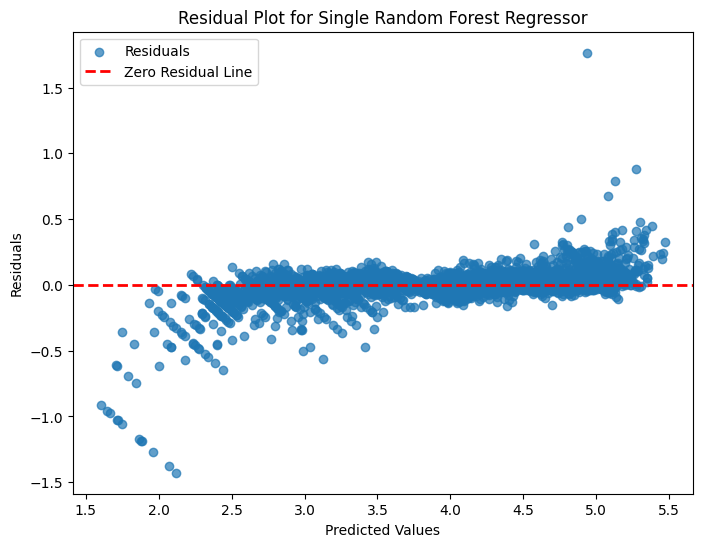

In [54]:
#Now look at the root mean squared error

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Root Mean Squared Error (RMSE) Single Random Forest: {rmse_rf:.2f}")

r_squared_rf = r2_score(y_test, rf_predictions)
print(f"R-Squared Single Random Forest): {r_squared_rf:.2f}")
# Calculate residuals
rf_residuals = y_test - rf_predictions

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(rf_predictions, rf_residuals, alpha=0.7, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Single Random Forest Regressor")
plt.legend()
plt.show()

In [55]:

rf_predictions_original = np.expm1(rf_predictions)  
y_test_original = np.expm1(y_test)  

rmse_rf_original = np.sqrt(mean_squared_error(y_test_original, rf_predictions_original))
print(f"RMSE on original scale: {rmse_rf_original}")

# Compute R-squared in the original scale
r_squared_rf_original = r2_score(y_test_original, rf_predictions_original)
print(f"R2 original scale: {r_squared_rf_original}")


RMSE on original scale: 11.533800049461766
R2 original scale: 0.9381241617311036


## Grid Search

Now I am going to try random forests in a grid search so that I can optimize over a bunch of different hyperparameters

In [56]:
rf_params = {"n_estimators": [100, 500],
    "max_depth": [10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [2, 5],
    "max_features": ["1.0", "sqrt"],
    "bootstrap": [True]}

#I have indicated which parameters I would like to mess around with
#First I instantiate a model
rf = RandomForestRegressor(random_state=42)
# Define a custom scorer for RMSE
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

#Now I start the grid search
rf_gs = GridSearchCV(rf, rf_params, scoring=rmse_scorer, cv=5, verbose=2, n_jobs=-1)

#now I need to fit that to my training
rf_gs.fit(X_train_fe, y_train)

#This takes forever to run so I don't want to have to run it every time
# Save the model (e.g., a RandomForestRegressor)
joblib.dump(rf_gs, 'random_forest_gs.pkl')

# # To load the model later
# rf_gs = joblib.load('random_forest_gs.pkl')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time

/Users/tomosharris/Desktop/Spiced/Coriander_Heatmap/Projects/ml-project-air-pollution/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tomosharris/Desktop/Spiced/Coriander_Heatmap/Projects/ml-project-air-pollution/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tomosharris/Desktop/Spiced/Coriander_Heatmap/Projects/ml-project-air-pollution/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest

KeyboardInterrupt: 

In [ ]:
rf_gs.best_params_

In [27]:
rf_gs_best = rf_gs.best_estimator_

In [28]:
rf_gs_preds = rf_gs_best.predict(X_test_fe)


In [ ]:
rmse_rf_gs = np.sqrt(mean_squared_error(y_test, rf_gs_preds))
print(f"Root Mean Squared Error for GS Test Data (RMSE): {rmse_rf_gs:.2f}")

r_squared_rf_gs = r2_score(y_test, rf_predictions)
print(f"R-Squared GS Test data): {r_squared_rf_gs:.2f}")

# Calculate residuals
rf_gs_residuals = y_test - rf_gs_preds

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(rf_gs_preds, rf_gs_residuals, alpha=0.7, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor on Test")
plt.legend()
plt.show()

In [ ]:
#Now i want to compare the RMSE on the train and test data to see if overfit
rf_gs_preds_train = rf_gs_best.predict(X_train_fe)
residuals_train_rf_gs = y_train - rf_gs_preds_train


rmse_train = np.sqrt(mean_squared_error(y_train, rf_gs_preds_train))
print(f"Root Mean Squared Error for GS Training Data (RMSE): {rmse_train:.2f}")
r_squared_rf_gs_train = r2_score(y_train, rf_gs_preds_train)
print(f"R-Squared GS Training Data: {r_squared_rf_gs_train:.2f}")

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(rf_gs_preds_train, residuals_train_rf_gs, alpha=0.7, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label="Zero Residual Line")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor on Train")
plt.legend()
plt.show()

Since we log-transformed our target variable, we want to understand these metrics in terms of predictions as they relate to actual PM2.5 values. To do this, we will exponentiate y_train and y_test and then assess performance

In [ ]:
rf_predictions_original = np.expm1(rf_predictions)  
y_test_original = np.expm1(y_test)  

rmse_rf_original = np.sqrt(mean_squared_error(y_test_original, rf_predictions_original))
print(f"RMSE on original scale: {rmse_rf_original}")

# Compute R-squared in the original scale
r_squared_rf_original = r2_score(y_test_original, rf_predictions_original)
print(f"R2 original scale: {r_squared_rf_original}")

In [ ]:
#To evaluate performance, we also need to scale our predictions

rf_gs_test_preds_exp = np.expm1(rf_gs_preds)
rf_gs_train_preds_exp = np.expm1(rf_gs_preds_train)

rmse_rf_gs_original = np.sqrt(mean_squared_error(y_test_original, rf_gs_test_preds_exp))
print(f"RMSE on test original scale: {rmse_rf_gs_original}")

r_squared_rf_gs_original = r2_score(y_test_original, rf_gs_test_preds_exp)
print(f"R2 test original scale: {r_squared_rf_gs_original}")

## XGBoost

In [36]:
from xgboost import XGBRegressor

We want to use XGBRegressor and want to test it with and without regularization to see if overfitting is greatly impacted and to determine if regularization is necessary. First we try WITHOUT regularization.

In [ ]:
#XGBoost WITHOUT Regularization
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,  # Reduce from 7 to 5
    colsample_bytree=0.7,
    subsample=0.8,
    reg_alpha = 1,
    reg_lambda = 2)


# Train the model
xgb.fit(X_train_fe, y_train)

# Evaluate again
xgb_y_train_pred = xgb.predict(X_train_fe)
xgb_y_test_pred = xgb.predict(X_test_fe)

xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_y_train_pred))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_test_pred))

xgb_train_r2 = r2_score(y_train, xgb_y_train_pred)
xgb_test_r2 = r2_score(y_test, xgb_y_test_pred)

print(f"Train RMSE: {xgb_train_rmse:.4f} | Test RMSE: {xgb_test_rmse:.4f}")
print(f"Train R²: {xgb_train_r2:.4f} | Test R²: {xgb_test_r2:.4f}")

In [ ]:
xgb_y_train_pred_original = np.expm1(xgb_y_train_pred)
xgb_y_test_pred_original = np.expm1(xgb_y_test_pred)



xgb_train_original_rmse = np.sqrt(mean_squared_error(y_train_original, xgb_y_train_pred_original))
xgb_test_original_rmse = np.sqrt(mean_squared_error(y_test_original, xgb_y_test_pred_original))

xgb_train_original_r2 = r2_score(y_train_original, xgb_y_train_pred_original)
xgb_test_original_r2 = r2_score(y_test_original, xgb_y_test_pred_original)

print(f"Train RMSE: {xgb_train_original_rmse:.4f} | Test RMSE: {xgb_test_original_rmse:.4f}")
print(f"Train R²: {xgb_train_original_r2:.4f} | Test R²: {xgb_test_original_r2:.4f}")

Train RMSE: 1.0114 | Test RMSE: 1.8349
Train R²: 0.9995 | Test R²: 0.9984

In [ ]:
#Optional: Second baseline model

#Predict the mean of y_train
y_train_mean = np.mean(y_train)
baseline_preds_2 = np.full_like(y_test, y_train_mean)  # Predict mean for every test point

mse_baseline_2 = mean_squared_error(y_test, baseline_preds_2)
rmse_baseline_2 = np.sqrt(mse_baseline_2)
print(f'The root mean-squared error for the second baseline model is {rmse_baseline_2}')